## CS 5990: Advanced Machine Learning Final Project

Mish Wilson and Cooper Sullivan

10/23/2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from IPython.display import Audio
from numpy.fft import fft, ifft
from os.path import dirname, join as pjoin
from scipy.io import wavfile
import torch.nn as nn

import scipy.io 
import os

import csv
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset, random_split

%matplotlib inline

import math, random
from pathlib import Path
import torch
import torchaudio
from torchaudio import transforms
import soundfile

In [2]:
# Test to see current working directory w correct files listed
os.listdir()

['.git',
 '.gitignore',
 '.venv',
 'classID.csv',
 'clips_rd',
 'load.py',
 'metadeta.csv',
 'ML-audio-chef.code-workspace',
 'prelim_results.ipynb',
 'README.md',
 'requirements.txt',
 'text_zone.ipynb']

In [3]:
# Test if we can read single file and get samplerate and data attributes
data_dir = pjoin(os.curdir, '.\clips_rd', 'aloe')
wav_fname = pjoin(data_dir, 'aloe_1_02.wav')
samplerate, data = wavfile.read(wav_fname)
print(f"length = {data.shape[0] / samplerate}s")
print(data.shape)

length = 2.9872562358276644s
(131738,)


C:\Users\Snoop\AppData\Local\Temp\ipykernel_30688\4114016665.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(wav_fname)


In [4]:
# Read single audio clip with regular IO function and call as audio
Fs, data = read('./clips_rd/aloe/aloe_1_02.wav')

Audio(data, rate=Fs)

C:\Users\Snoop\AppData\Local\Temp\ipykernel_30688\311687441.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = read('./clips_rd/aloe/aloe_1_02.wav')


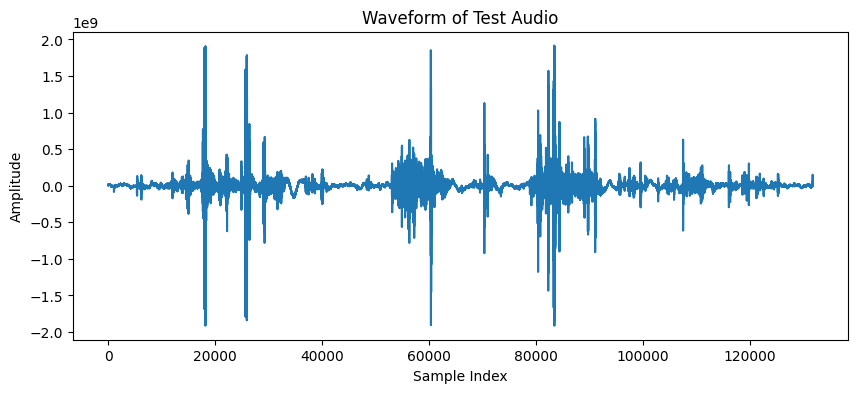

In [5]:
# Plot waveform to better understand visualness of audio
plt.figure(figsize=(10, 4))
plt.plot(data)
plt.xlabel("Sample Index")
plt.ylabel('Amplitude')
plt.title('Waveform of Test Audio')
plt.show()

Each audio sample in the dataset such as its filename, its class label, the ‘fold’ sub-folder location, and so on.

We will create a CSV to store path data for loading. Format: relative_path, classID, label

In [6]:
# Display food labels
path = os.getcwd() + "/clips_rd" 
food_categories = os.listdir(path) 
print("Files and directories in '", path, "' :")  
print(food_categories)

Files and directories in ' c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef/clips_rd ' :
['aloe', 'burger', 'cabbage', 'candied_fruits', 'carrots', 'chips', 'chocolate', 'drinks', 'fries', 'grapes', 'gummies', 'ice-cream', 'jelly', 'noodles', 'pickles', 'pizza', 'ribs', 'salmon', 'soup', 'wings']


In [7]:
# Create general CSV for label referencing

data = [['class', 'classID']]
for i, food in enumerate(food_categories):
    data.append([food, i+1])

# Create file path for the CSV file
csv_file_path = 'classID.csv'

# Open the file in write mode
with open(csv_file_path, mode='w', newline='') as file:
    # Create a csv.writer object
    writer = csv.writer(file)
    # Write data to the CSV file
    writer.writerows(data)

In [8]:
os.getcwd()

'c:\\Users\\Snoop\\OneDrive - University of Vermont\\Documents\\University of Vermont\\Machine Learning\\ML-audio-chef'

In [9]:
# Create metadata CSV file to store audio paths as well as ID and labels

data = [['relative_path', 'classID', 'label']]
for i, food in enumerate(food_categories):
    path = os.getcwd() + "\\clips_rd\\" + food
    wavs = os.listdir(path)
    for wav in wavs:
        data.append([f"./clips_rd/{food}/{wav}",i, food])

print(data)

# File path for the CSV file
csv_file_path = 'metadeta.csv'

# Open the file in write mode
with open(csv_file_path, mode='w', newline='') as file:
    # Create a csv.writer object
    writer = csv.writer(file)
    # Write data to the CSV file
    writer.writerows(data)

[['relative_path', 'classID', 'label'], ['./clips_rd/aloe/aloe_10_01.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_02.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_03.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_04.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_05.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_06.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_07.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_08.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_09.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_10.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_11.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_12.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_13.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_14.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_15.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_16.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_17.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_18.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_19.wav', 0, 'aloe'], ['./clips_rd/aloe/aloe_10_20.wav', 0, 'aloe'], ['./clips_rd/aloe/al

## Tranforming Data / Audio Files

Here we transform the data so that its in a format the model expects. This can be done during runtime. 

Audio files tend to be large- so we're keeping only the audio file names in our taining data.

Then at run time, as we train the model we'll load the audio data for that bath and then process it. This way we keep audiodata for only one batch in memory at a time reducing the overall strain on system by loading everything in all at once and having to store it all.

Transforms:
- Load Audio file
- Resample and convert to stereo or mono
    - Testing on aloe- so far all the files seem to have 1 channel so no need to convert them!
- resize to fixed length so all the audios are the same length
- audio augmentation time shift
- convert to mel spectogram
- spectogram augmentation. SPECAUGMENTATING TIME!!

Potential audio processing libraries:
- librosa
    - slower that pytorch
    - seems to be used for smaller datasets?
    - usually used for making spectograms- but since pytorch came out with torchaudio it isn't used as much by new learners- usually used by people who are used to the library. 
- pytorch (torchaudio)
    - pretty fast
    - may be better for such a large data set
    - well documented (in my opinion)
    - we'll be using pytorch anyway to processed the spectrogram- so we probably should just use torchaudio??
- audio flux
    - super fast
    - fairly new
    - less digital examples to follow when learning

## Load in Data

In [10]:
torchaudio.set_audio_backend("soundfile")

def open_audio(audio_file):
    signal, sample_rate = torchaudio.load(audio_file)
    return signal, sample_rate

df = pd.read_csv('metadeta.csv')

# Check if audio file backend exists
# Output should be ['soundfile']. If output is [] then redownload libraries in specific order.
print(torchaudio.list_audio_backends())


['soundfile']


C:\Users\Snoop\AppData\Local\Temp\ipykernel_30688\1271497217.py:1: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [11]:
# Using Open Audio, for now we're just using aloe
audio_files = []

# Keep track incase not all files are correctly loaded
success = 0
fail = 0

for audio in df[df['label'] == 'aloe']['relative_path']:
    try:
        audio_files.append(open_audio(audio))
        success += 1
    except RuntimeError:
        fail += 1
        print(f"Skipping file: {audio}")
print(f"Successes: {success}\nFails: {fail}")

Successes: 546
Fails: 0


In [12]:
# Test code to ensure audio loaded correctly

test_signal, test_sr = audio_files[0]

# for audio in audio_files:
#     print(audio[1])

len(test_signal) / test_sr
test_signal.shape[0]

#154293 // 1000 * 3000



1

## Audio Before Transformations

Text(0.5, 1.0, 'Original Waveform')

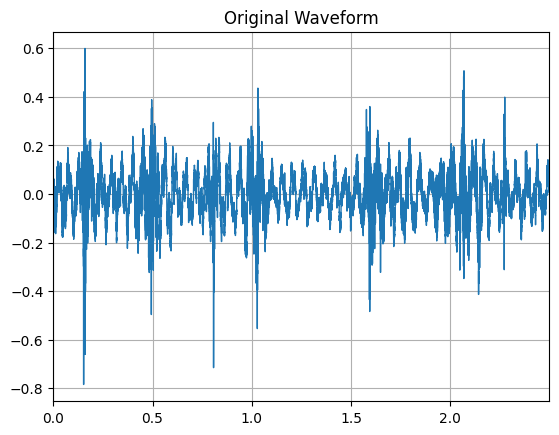

In [13]:
waveform, sr = audio_files[1]
fig, axs = plt.subplots(1, 1)

waveform = waveform.numpy()
num_channels, num_frames = waveform.shape
time_axis = torch.arange(0, num_frames) / sr

ax = axs
ax.plot(time_axis, waveform[0], linewidth=1)
ax.grid(True)
ax.set_xlim([0, time_axis[-1]])
ax.set_title("Original Waveform")

## Transform Sample Rate
Just looping through and making sure all the audio files have the same sample rate! Majority seem to be 44100Hz- but just to make sure I'll loop through to catch any that aren't.

In [14]:
# Resample takes in audio file (aud) and desired sample rate (newsr) and ensures they match
def resample(aud, newsr):
    signal, sr = aud

    if (sr == newsr):
      return audio
        
    # Resample channel
    re_signal = torchaudio.transforms.Resample(sr, newsr)(signal[:1,:])
    

    return ((re_signal, newsr))

In [15]:
# Loop through and resample all audio so its on the same page (44100Hz)
t_audio_files = []
for audio in audio_files:
    t_audio_files.append(resample(audio, 44100))

audio_files = t_audio_files

## Resizing Audio Lengths

Resizing  samples to be the same length. Found that they are infact different lengths ranging between 2 and 4? I think I'll just average it out to 3 seconds each. Padding it out with silence if its 2 seconds and truncating if its 4? We can change this if this is bad.

Math to find length of clips: 
Sample Rate // 44100 Hz 

In [16]:
def resize(aud, max_ms):
    signal, sample_rate = aud
    num_rows, signal_len = signal.shape

    # calculate what would make audio max_ms long
    max_len = sample_rate//1000 * max_ms

    if (signal_len > max_len):
      # Truncate signal
      signal = signal[:,:max_len]

    elif (signal_len < max_len):
      # Pad audio with silence instead. At beginning and end.
      pad_begin_len = random.randint(0, max_len - signal_len)
      pad_end_len = max_len - signal_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      signal = torch.cat((pad_begin, signal, pad_end), 1)
      
    return (signal, sample_rate)
   

In [17]:
# Loop through and resize all audio so they're all 3 seconds long (3000 miliseconds)
t_audio_files = []
for audio in audio_files:
    t_audio_files.append(resize(audio, 3000))

audio_files = t_audio_files

## Time Shift
Not sure if we need to do this augmentation shince I think we have a pretty diverse dataset? But We can return to this incase we do.

## Mel Spectrogram Creation.

Time to creat some spectrograms! Specifically Mel Spectrograms instead of jsut Spectrograms as they are better for training models it seems.

"The mel-spectrogram, based on the auditory-based mel-frequency scale, provides better resolution for lower frequencies than the spectrogram"

In [18]:
# n_mels : Number of mel filterbanks
# n_fft : Size of FFT
# hop_len : Length of hop between STFT windows
def spectrogram(audio, n_mels=64, n_fft=1024, hop_len=None):
    signal, sample_rate = audio
    top_db = 80

    # spectrogram shape is [channel, n_mels, time]
    spec = transforms.MelSpectrogram(sample_rate, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(signal)

    # Convert to decibels 
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return spec

In [19]:
spec = spectrogram(audio_files[1])


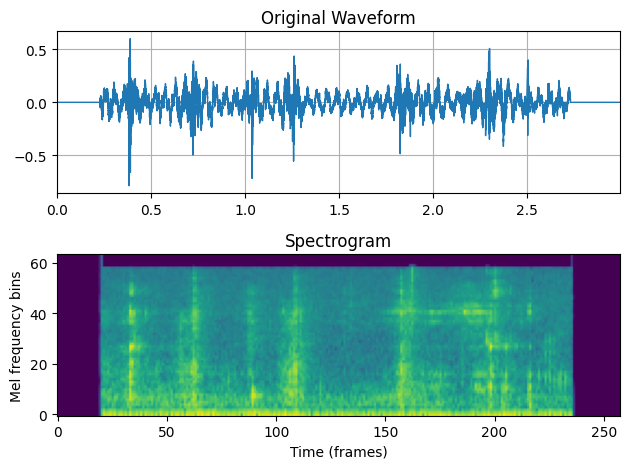

In [20]:
def plot_spectrogram(spec, title='Spectrogram'):
    # Convert the tensor to a numpy array and squeeze to 2D
    spec = spec.squeeze().numpy()

    plt.figure(figsize=(10, 4))
    plt.imshow(spec, aspect='auto', origin='lower')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Time (frames)')
    plt.ylabel('Mel frequency bins')
    return plt

# plot_spectrogram(spec, title='Spectrogram')

spec = spectrogram(audio_files[1])
waveform, sr = audio_files[1]
fig, axs = plt.subplots(2, 1)

waveform = waveform.numpy()
num_channels, num_frames = waveform.shape
time_axis = torch.arange(0, num_frames) / sr

ax = axs[0]
ax.plot(time_axis, waveform[0], linewidth=1)
ax.grid(True)
ax.set_xlim([0, time_axis[-1]])
ax.set_title("Original Waveform")

s_spec = spec.squeeze().numpy()

ax = axs[1]
ax.imshow(s_spec, aspect='auto', origin='lower')
ax.set_title("Spectrogram")
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Mel frequency bins')

fig.tight_layout()

# SPEC Augmentation
Time and Frequency Masking!

fREQUENCY mASK: Randomly Mask out a range of consecutive frequencies by adding horizonatal bars to our spectro gram

Time Mask: Randomly block out ranges of time from the spectrogram by using vertical bars.

We do this to prevent voerfitting and to help the model generalize better. The masked sections get replaced with a mean value :0 Which is pretty cool!!

In [21]:
spec.shape
# ..., number of mels, number of steps (time)
# Documentation literally says the first index is '...'

torch.Size([1, 64, 258])

In [22]:
# Defaulting to 10% and only one mask until we deiscuss what would 
# be most optional :)
def spec_mask(spec, max_mask_pct=0.1, num_freq_masks=1, num_time_masks=1):
    _, num_mels, num_steps = spec.shape
    
    # Get the average to replace the blocked zones
    mask_val = spec.mean()
    augment_spec = spec
    
    # Add frquency mask- will look like a horizonal bar
    freq_mask_param = max_mask_pct * num_mels
    for _ in range(num_freq_masks):
        augment_spec = transforms.FrequencyMasking(freq_mask_param)(augment_spec, mask_val)

    # Add time mask- will look like a vertical bar
    time_mask_param = max_mask_pct * num_steps
    for _ in range(num_time_masks):
        augment_spec = transforms.TimeMasking(time_mask_param)(augment_spec,mask_val)

    return augment_spec

## Before Masking

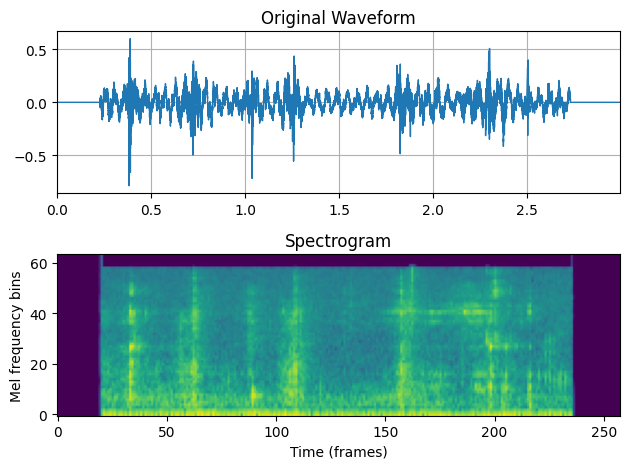

In [23]:
spec = spectrogram(audio_files[1])
waveform, sr = audio_files[1]
fig, axs = plt.subplots(2, 1)

waveform = waveform.numpy()
num_channels, num_frames = waveform.shape
time_axis = torch.arange(0, num_frames) / sr

ax = axs[0]
ax.plot(time_axis, waveform[0], linewidth=1)
ax.grid(True)
ax.set_xlim([0, time_axis[-1]])
ax.set_title("Original Waveform")

s_spec = spec.squeeze().numpy()

ax = axs[1]
ax.imshow(s_spec, aspect='auto', origin='lower')
ax.set_title("Spectrogram")
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Mel frequency bins')

fig.tight_layout()



## After Masking

In [24]:
spec = spectrogram(audio_files[1])
spec = spec_mask(spec)

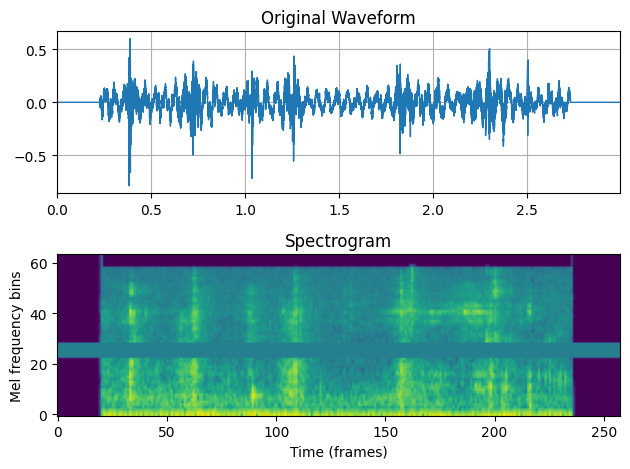

In [25]:
waveform, sr = audio_files[1]
fig, axs = plt.subplots(2, 1)

waveform = waveform.numpy()
num_channels, num_frames = waveform.shape
time_axis = torch.arange(0, num_frames) / sr

ax = axs[0]
ax.plot(time_axis, waveform[0], linewidth=1)
ax.grid(True)
ax.set_xlim([0, time_axis[-1]])
ax.set_title("Original Waveform")

s_spec = spec.squeeze().numpy()

ax = axs[1]
ax.imshow(s_spec, aspect='auto', origin='lower')
ax.set_title("Spectrogram")
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Mel frequency bins')

fig.tight_layout()

# Data Loader for Model
- dataset Object that tranforms the audio- preping each data item
- DataLoader from torch- to fecth the sata items and packages them to batches

In [26]:
# Group together audio opening function as well as audio transformation functions into a convenient class
class AudioFuncs():
    
    def open_audio(audio_file):
        signal, sample_rate = torchaudio.load(audio_file)
        return signal, sample_rate


    # Resample takes in audio file (aud) and desired sample rate (newsr) and ensures they match
    def resample(aud, newsr):
        signal, sr = aud

        if (sr == newsr):
            return audio
            
        # Resample channel
        re_signal = torchaudio.transforms.Resample(sr, newsr)(signal[:1,:])
    
        return ((re_signal, newsr))


    # Resize audio to be of specific time length (max_ms)
    def resize(aud, max_ms):
        signal, sample_rate = aud
        num_rows, signal_len = signal.shape

        # calculate what would make audio max_ms long
        max_len = sample_rate//1000 * max_ms

        if (signal_len > max_len):
            # Truncate signal
            signal = signal[:,:max_len]

        elif (signal_len < max_len):
            # Pad audio with silence instead. At beginning and end.
            pad_begin_len = random.randint(0, max_len - signal_len)
            pad_end_len = max_len - signal_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            signal = torch.cat((pad_begin, signal, pad_end), 1)
        
        return (signal, sample_rate)


    # Rechannel audio
    def rechannel(audio, max_channels):
        
        signal, sr = audio

        # Verify audio isn't already correct number of channels 
        if (signal.shape[0] == max_channels):
            return audio
        
        # If audio channels > max_channels -> Reduce channels to max_channels
        if (signal.shape[0] > max_channels):
            new_signal = signal[:max_channels, :]
            
        else:
             # If audio channels < max_channels -> Add extra channels to reach max_channels
            num_current_channels = signal.shape[0]
            num_channels_to_add = max_channels - num_current_channels
            
            # Calculate full duplications and the remaining channels needed
            full_duplications = num_channels_to_add // num_current_channels
            remaining_channels = num_channels_to_add % num_current_channels

            # Duplicate the signal for full duplications
            new_signal = torch.cat([signal] * (full_duplications + 1), dim=0)

            # Add the remaining channels (if any) by slicing from the original signal
            if remaining_channels > 0:
                new_signal = torch.cat([new_signal, signal[:remaining_channels, :]], dim=0)

        return (new_signal[:max_channels, :], sr)


    # Creates spectrogram for given audio sample with specified mel bins and Fourier transformations.
    def spectrogram(audio, n_mels=128, n_fft=1024, hop_len=None):
        signal, sample_rate = audio
        top_db = 80

        # spectrogram shape is [channel, n_mels, time]
        spec = transforms.MelSpectrogram(sample_rate, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(signal)

        # Convert to decibels 
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return spec
    

    # Visualize given spectrogram (spec) with matplotlib
    def plot_spectrogram(spec, title='Spectrogram'):
        # Convert the tensor to a numpy array and squeeze to 2D
        spec = spec.squeeze().numpy()

        plt.figure(figsize=(10, 4))
        plt.imshow(spec, aspect='auto', origin='lower')
        plt.colorbar()
        plt.title(title)
        plt.xlabel('Time (frames)')
        plt.ylabel('Mel frequency bins')
        return plt
    

    # Mask a percentage of the given spectrogram with averaging data to in theory reduce overfitting when training data. 
    # Defaulting to 10% and only one mask until we deiscuss what would be most optional for generalizing :)
    def spec_mask(spec, max_mask_pct=0.1, num_freq_masks=1, num_time_masks=1):
        _, num_mels, num_steps = spec.shape
        
        # Get the average to replace the blocked zones
        mask_val = spec.mean()
        augment_spec = spec
        
        # Add frquency mask- will look like a horizonal bar
        freq_mask_param = max_mask_pct * num_mels
        for _ in range(num_freq_masks):
            augment_spec = transforms.FrequencyMasking(freq_mask_param)(augment_spec, mask_val)

        # Add time mask- will look like a vertical bar
        time_mask_param = max_mask_pct * num_steps
        for _ in range(num_time_masks):
            augment_spec = transforms.TimeMasking(time_mask_param)(augment_spec,mask_val)

        return augment_spec


In [27]:
class FoodAudioDS(Dataset):
    def __init__(self, df, dir_path, transform=None, target_transform=None):
        self.df = df
        self.dir_path = dir_path
        #self.transform = transform
        #self.target_transform = target_transform

        self.duration = 3000
        self.sample_rate = 44100
        self.channel = 1

    def __len__(self):
        return len(self.df)  

    def __getitem__(self, idx):

        # Get the Audio file location- using curr directory path and then files
        # relative path
        audio_file = self.dir_path + self.df.loc[idx, 'relative_path']
        
        # Get the Class ID
        class_id = self.df.loc[idx, 'classID']

        aud = AudioFuncs.open_audio(audio_file)
        
        # Tranformations for Audio
        reaud = AudioFuncs.resample(aud, self.sample_rate)
        rechan = AudioFuncs.rechannel(reaud, self.duration)
        dur_aud = AudioFuncs.resize(reaud, self.duration)

        # Create and Transform Spectrogram
        sgram = AudioFuncs.spectrogram(dur_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioFuncs.spec_mask(sgram, max_mask_pct=0.1, num_freq_masks=1, num_time_masks=1)

        # Return spectrogram and classID
        return aug_sgram, class_id

In [28]:
dir_path = os.getcwd()

# Get the total number of samples
total_samples = len(df)
subset_size = round(total_samples * 0.1)
subset_indices = random.sample(range(total_samples), subset_size)
df_subset = df.iloc[subset_indices].reset_index(drop=True)

# Create a FoodAudioDS instance with the reduced DataFrame
food_ds = FoodAudioDS(df_subset, dir_path)

#food_ds = FoodAudioDS(df, dir_path)
#food_ds = FoodAudioDS(df[df['label'] == 'aloe'], dir_path)


# split data 80:20 between training and validation
num_items = len(food_ds)
num_train_data = round(num_items * 0.8)
num_test = num_items - num_train_data
train_ds, test_ds = random_split(food_ds, [num_train_data, num_test])

# training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False)

In [29]:
len(food_ds)

1114

## CNN Model
blah blah blah


In [ ]:
from torchsummary import summary
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

class CNN_Model(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32,kernel_size=3,stride=1,padding=1),
            ## Normalize
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(0.2)  # Added dropout
            
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=1,padding=1),
            ## Normalize
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(0.2)
        )
        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3,stride=1,padding=1),
            ## Normalize
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(0.1)        
        )
        self.conv4=nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,stride=1,padding=1),
            ## Normalize
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.1) 
        )
        self.flatten=nn.Flatten()
        self.fc1=nn.Sequential(
            nn.Linear(128, 64),  # Reduced feature dimensions
            nn.ReLU(),
            nn.Dropout(0.1)  # Final dropout before the last layer
        )
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x: torch.Tensor):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            x = self.flatten(x)
            x = self.fc1(x)
            try:
                x = self.fc2(x)
            except Exception as e:
                print(f"Error : Linear block should take support shape of {x.shape} for in_features.")
            return x

#device = torch.device("cpu")
                
food_model = CNN_Model()
#food_model = food_model.to('cpu')

if torch.cuda.is_available():
     food_model.cuda()

print("Model summary : ")
print(summary(food_model, (1, 64, 258)))

Model summary : 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 64, 258]             160
       BatchNorm2d-2          [-1, 16, 64, 258]              32
              ReLU-3          [-1, 16, 64, 258]               0
         MaxPool2d-4          [-1, 16, 32, 129]               0
           Dropout-5          [-1, 16, 32, 129]               0
            Conv2d-6          [-1, 32, 32, 129]           4,640
       BatchNorm2d-7          [-1, 32, 32, 129]              64
              ReLU-8          [-1, 32, 32, 129]               0
         MaxPool2d-9           [-1, 32, 16, 64]               0
          Dropout-10           [-1, 32, 16, 64]               0
           Conv2d-11           [-1, 64, 16, 64]          18,496
      BatchNorm2d-12           [-1, 64, 16, 64]             128
             ReLU-13           [-1, 64, 16, 64]               0
        MaxPool2d-14  

## Code for training model

In [33]:
def train(model, train_loader, num_epoch):
    print("Initializing training process...")

    device = torch.device("cuda")
    model.to(device)
    print("Model moved to CUDA.")

    # Loss Function, Optimizer
    print("Setting up loss function, optimizer, and learning rate scheduler.")
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.002,
                                                   steps_per_epoch=int(len(train_loader)),
                                                   epochs=num_epoch,
                                                   anneal_strategy='linear')
    lrs = []

    print("Starting training loop...")
    # Repeat per epoch
    for epoch in range(num_epoch):
        print(f"Epoch {epoch + 1}/{num_epoch}...")
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Rep for each batch in train
        for batch_idx, (data, target) in enumerate(train_loader):
            print(f"Processing batch {batch_idx + 1}/{len(train_loader)}...")
            # Get the input features and target labels
            inputs, labels = data.to(device), target.to(device)
            #print("Transferred data to device.")

            # Normalize the input
            inputs = (inputs - torch.mean(inputs)) / torch.std(inputs)

            inputs = (inputs - inputs.mean(dim=[0, 2, 3], keepdim=True)) / inputs.std(dim=[0, 2, 3], keepdim=True)
            #print("Normalized inputs.")

            # Zero the gradients
            optimizer.zero_grad()

            # Forward, backward, optimize
            #print("Performing forward pass...")
            outputs = model(inputs)
            
            #print("Calculating loss and performing backward pass...")
            loss = criterion(outputs, labels)
            loss.backward()

            #print("Updating weights...")
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs, 1)
            
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            # Collect learning rate
            lrs.append(optimizer.param_groups[0]['lr'])

            print('[Epoch: %d, Batch_Idx: %d, Accuracy: %.3f] loss: %.3f' % (epoch + 1, batch_idx + 1, correct_prediction / total_prediction, running_loss / (batch_idx + 1)))

        # Print stats
        num_batches = len(train_loader)
        avg_loss = running_loss / num_batches
        accuracy = correct_prediction / total_prediction
        print(f"Epoch {epoch + 1} complete. Loss: {avg_loss:.2f}, Accuracy: {accuracy:.2f}")

    print("Training process complete!")

    # Plot the learning rate schedule
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(lrs)), lrs)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule During Training")
    plt.grid(True)
    plt.show()


train(food_model, train_dl, num_epoch=2)

Initializing training process...
Model moved to CUDA.
Setting up loss function, optimizer, and learning rate scheduler.
Starting training loop...
Epoch 1/2...
Processing batch 1/14...
[Epoch: 1, Batch_Idx: 1, Accuracy: 0.016] loss: 3.023
Processing batch 2/14...
[Epoch: 1, Batch_Idx: 2, Accuracy: 0.031] loss: 3.018
Processing batch 3/14...
[Epoch: 1, Batch_Idx: 3, Accuracy: 0.031] loss: 3.012
Processing batch 4/14...
[Epoch: 1, Batch_Idx: 4, Accuracy: 0.031] loss: 3.018
Processing batch 5/14...
[Epoch: 1, Batch_Idx: 5, Accuracy: 0.034] loss: 3.018


KeyboardInterrupt: 

In [ ]:
CUDA_LAUNCH_BLOCKING=1 python your_script.py


In [73]:
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu")), data[1].to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(food_model, test_dl)

Accuracy: 0.04, Total items: 223
